In [0]:
import torch
# Check if pytorch is using GPU:
print('Used device name: {}'.format(torch.cuda.get_device_name(0)))

Used device name: Tesla P100-PCIE-16GB


Import your google drive if necessary.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import sys
import os
ROOT_DIR = 'your_dir'
sys.path.insert(0, ROOT_DIR)
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
% matplotlib inline

After trraining preprocessing the data and training the model, load all the needed files.

In [0]:
resources_dir = os.path.join(ROOT_DIR, 'resources', '')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vocabulary = pickle.load(open(os.path.join(os.path.join(resources_dir, 'vocabulary'), 'vocabulary.pickle'), 'rb'))
word2vec_path = 'your_path/idx2vec.pickle'
word2idx = pickle.load(open(os.path.join(os.path.join(resources_dir, 'word2idx'), 'word2idx.pickle'), 'rb'))
idx2word = pickle.load(open(os.path.join(os.path.join(resources_dir, 'idx2word'), 'idx2word.pickle'), 'rb'))
word_count = pickle.load(open(os.path.join(os.path.join(resources_dir, 'word_counts'), 'word_counts.pickle'), 'rb'))

embeddings_weigths = pickle.load(open(word2vec_path, 'rb'))
embeddings_weigths = torch.tensor(embeddings_weigths).to(device)

In [0]:
embeddings_weigths[1]

tensor([ 8.9383e-04, -7.9303e-04,  1.6415e-03, -5.6756e-04,  3.9209e-04,
         1.5539e-03, -1.3896e-03,  1.2225e-03,  1.0120e-03, -1.4705e-04,
        -1.0854e-03, -4.0771e-05,  3.4775e-04,  1.6318e-03,  1.2514e-03,
         1.2114e-03,  9.1972e-04, -8.1595e-04, -2.0925e-04,  1.5085e-03,
        -5.2567e-04, -1.4169e-03,  1.5322e-03, -1.5125e-03, -1.1296e-03,
         2.8627e-04,  8.5131e-04, -2.0004e-05,  6.6250e-04, -1.5177e-03,
         2.1029e-04,  7.1049e-04, -8.7924e-05, -1.1748e-03, -6.2265e-05,
         3.3644e-04, -2.2081e-04, -5.7105e-04, -1.5586e-03,  1.1065e-03,
        -5.6389e-04, -1.0361e-03, -4.8426e-04, -1.2710e-03, -1.4100e-03,
        -1.0480e-03, -8.1121e-04, -1.3160e-03,  5.2606e-04, -4.3782e-04,
        -8.1941e-04, -9.1800e-04, -9.4242e-04,  7.7848e-04, -7.5610e-04,
        -3.7023e-05,  3.2481e-04, -1.1929e-03, -2.8775e-04, -1.2705e-03,
        -1.5896e-03, -3.2531e-05,  1.4354e-03,  2.5280e-04,  4.0717e-04,
         1.0641e-03,  7.3059e-04,  1.4369e-03,  1.0

Define the cosine similarity between two vectors.


In [0]:
def cosine_sim(x_vector, y_vector):
    dot_prod = torch.dot(x_vector.T, y_vector)
    vector_norms = torch.sqrt(torch.sum(x_vector**2)) * torch.sqrt(torch.sum(y_vector**2))
    similarity = dot_prod / vector_norms
    return similarity

Plot results from t-SNE for a group of selected words.

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.001s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1.050818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.196255
[t-SNE] KL divergence after 2950 iterations: 0.471334


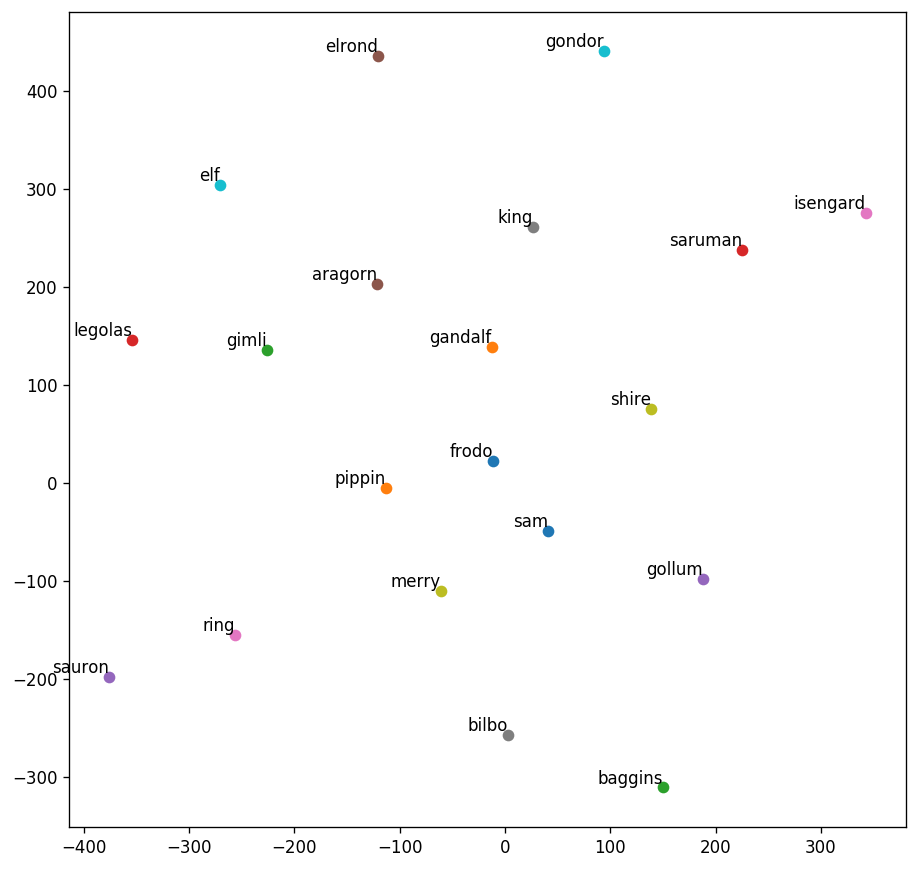

In [0]:
test_words = ['frodo', 'gandalf', 'gimli', 'saruman', 'sauron', 'aragorn', 'ring', 'bilbo', 
              'shire', 'gondor', 'sam', 'pippin', 'baggins', 'legolas',
              'gollum', 'elrond', 'isengard', 'king', 'merry', 'elf']
test_idx = [word2idx[word] for word in test_words]
test_embds = embeddings_weigths[test_idx]

tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=10000, random_state=12, 
            verbose=1)
test_embds_2d = tsne.fit_transform(test_embds.cpu().numpy())

plt.figure(figsize = (9, 9), dpi=120)
for idx, word in enumerate(test_words):

    plt.scatter(test_embds_2d[idx][0], test_embds_2d[idx][1])
    plt.annotate(word, xy = (test_embds_2d[idx][0], test_embds_2d[idx][1]), \
        ha='right',va='bottom')

plt.show()

Compute cosine similarities for a group of selected words.

In [0]:
words = ['frodo', 'gandalf', 'gimli', 'saruman', 'sauron', 'aragorn', 'ring', 'bilbo', 
              'shire', 'gondor', 'sam', 'pippin', 'baggins', 'legolas',
              'gollum', 'elrond', 'isengard', 'king', 'merry', 'elf']
words_idx = [word2idx[word] for word in words]
embeddings_words = [embeddings_weigths[idx] for idx in words_idx]

top_num = 5

t = tqdm(embeddings_words)
t.set_description('Checking words for similarities')

similarities = {}
for idx_1, word_1 in enumerate(t):
    key_word = words[idx_1]
    similarities[key_word] = []
    for idx_2, word_2 in enumerate(embeddings_weigths):
        # the first two elements in vocab are padding word and unk word
        if idx_2 > 1:
            similarity = float(cosine_sim(word_1, word_2))
            if word2idx[key_word] != idx_2:
                similarities[key_word].append([idx2word[idx_2], similarity])
    similarities[key_word].sort(key= lambda x: x[1])
    similarities[key_word] = similarities[key_word][:-top_num-1:-1]

for key in similarities:
    for item in similarities[key]:
        item[1] = round(item[1], 4)

Format the results and convert them into a pandas dataframe.


In [0]:
formated_sim = {}
for key in similarities:
    temp_list = []
    for items in similarities[key]:
        string = '"{}": {}'.format(items[0], items[1])
        temp_list.append(string)
    formated_sim[key] = temp_list

df = pd.DataFrame(data=formated_sim)

In [0]:
df

,frodo,gandalf,gimli,saruman,sauron,aragorn,ring,bilbo,shire,gondor,sam,pippin,baggins,legolas,gollum,elrond,isengard,king,merry,elf
0,"""he"": 0.6002","""he"": 0.4784","""legolas"": 0.4909","""radagast"": 0.4281","""enemy"": 0.3498","""omer"": 0.4439","""ruling"": 0.4364","""frodo"": 0.4945","""sale"": 0.4068","""ancient"": 0.3373","""frodo"": 0.5621","""frodo"": 0.4902","""mr"": 0.4232","""gimli"": 0.4909","""yess"": 0.4457","""gravely"": 0.3374","""saruman"": 0.4059","""lord"": 0.4245","""pippin"": 0.4648","""dwarf"": 0.3674"
1,"""sam"": 0.5621","""i"": 0.436","""aragorn"": 0.4373","""isengard"": 0.4059","""ring"": 0.3239","""gimli"": 0.4373","""rings"": 0.3321","""he"": 0.4088","""r"": 0.3842","""nmenor"": 0.3307","""he"": 0.5288","""he"": 0.4774","""bilbo"": 0.3905","""aragorn"": 0.4058","""ach"": 0.4321","""arwen"": 0.3219","""war"": 0.3026","""thoden"": 0.3964","""sam"": 0.454","""kingsfoil"": 0.3405"
2,"""bilbo"": 0.4945","""frodo"": 0.4327","""gandalf"": 0.4219","""gandalf"": 0.3833","""bred"": 0.3197","""boromir"": 0.4161","""sauron"": 0.3239","""baggins"": 0.3905","""neighbourhood"": 0.3427","""city"": 0.3303","""pippin"": 0.4657","""sam"": 0.4657","""underhill"": 0.3824","""gandalf"": 0.3884","""he"": 0.4234","""imladris"": 0.3123","""rohan"": 0.2995","""thengel"": 0.3872","""frodo"": 0.4482","""dunland"": 0.3071"
3,"""pippin"": 0.4902","""hoo"": 0.4231","""glins"": 0.3845","""traitor"": 0.3723","""rings"": 0.319","""legolas"": 0.4058","""claim"": 0.3231","""mr"": 0.3879","""brandywine"": 0.3425","""errandriders"": 0.3301","""mr"": 0.4622","""merry"": 0.4648","""money"": 0.3631","""bregalad"": 0.3538","""precious"": 0.3913","""elronds"": 0.3092","""hosts"": 0.2995","""omer"": 0.3836","""gandalf"": 0.3994","""glins"": 0.3049"
4,"""mr"": 0.4562","""gimli"": 0.4219","""sam"": 0.372","""treason"": 0.3674","""destroyed"": 0.3164","""gandalf"": 0.4017","""destroy"": 0.3204","""merry"": 0.3675","""days"": 0.3404","""men"": 0.326","""merry"": 0.454","""gandalf"": 0.3967","""alarmed"": 0.3375","""arod"": 0.3372","""smagol"": 0.3812","""dnedain"": 0.3038","""thither"": 0.2966","""kings"": 0.3829","""bilbo"": 0.3675","""eldest"": 0.304"
